## BC203: Assignment 2 – Clustering

**Author:** Georgios Kousis Tsampazis

---

### Background

Clustering is the task of dividing the population or data points into several groups. Data points in the same
group are similar to those in the same group and dissimilar to those in the different groups. It is a collection
of objects based on their similarities and dissimilarities.

### Overview

Your assignment is to execute clustering methods on a synthetic data set derived from the well-known
machine learning module in Python called scikit-learn (https://scikit-learn.org/stable/). We will generate
synthetic data in the multidimensional space.

---

### Part 1: Custom Kmeans

1. **Data Generation**

   * Use the function `sklearn.datasets.make_blobs`.
2. **Costum Kmeans Function**
   * Init centers 
   * Repeat until convergence:
      a. Compute Di,kDi,k​ for each distance metric
      b. Assign each point to nearest center
      c. Recompute centers (handle empty clusters)
      d. Check shift < tol
   * Return final centers, labels, and inertia
3. **Mixture of Gaussians Function**
   a. Random initialization
   b. K-means initialization

---
### Part 2: Visualization

### Part 3: Noise Comparison

1. **Generate Noisy Data**
2. **Compare different algorithms**

---

## Notebook Structure

1. **Setup & Dependencies**

2. **Data Preparation**

3. **Algorithms Implementation**

4. **Visualization & Interpretation**
5. **Discussion**

---

> *>Our Analysis shows that there are three kinds of people in the world:* \
*>Those who use k-means clustering with k=3, and two other types whose qualitive interpretation is unclear* 

---


### Noteboook dependencies
*As always a conda enviroment is recommended for easier installation*

In [5]:
pip install scikit-learn numpy matplotlib seaborn pandas

Note: you may need to restart the kernel to use updated packages.


### Data Generation

We use scikit-learn’s `make_blobs` to generate a toy clustering dataset with 1,000 samples in 10-dimensional space. The points are drawn from four Gaussian clusters (std = 3.0), and for reproducibility we set `random_state` to the last two digits of my student ID.


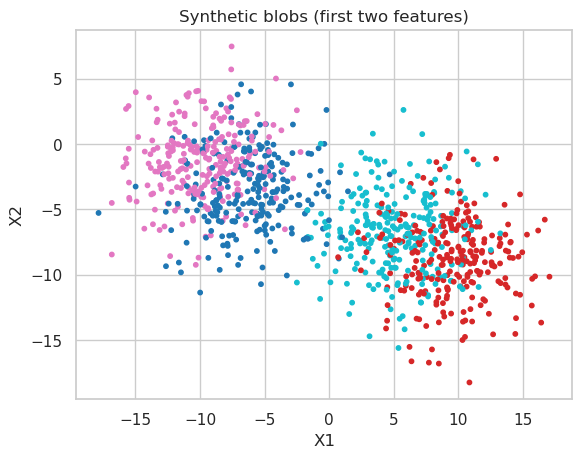

In [6]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000,n_features=10,centers=4,cluster_std=3.0,random_state=91)
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap='tab10')
plt.title("Synthetic blobs (first two features)")
plt.xlabel("X1"); plt.ylabel("X2")
plt.show()

Figure 1: Scatter plot of synthetic data (first two features) generated `using make_blobs`. True cluster labels are shown by color. Standard deviation is set to 3.0, resulting in 4 moderately separated clusters.

### Custom K-Means Function

The `kmeans` function clusters an input dataset `data` into `n_clusters` using a manual K-Means algorithm. It supports three distance metrics `euclidean`, `manhattan`, and `mahalanobis`. It initializes centroids with the **K-Means++** strategy (default) or **uniform random seeding**. The function iterates assignment and update steps until centroid movement falls below a tolerance (`tol`) or a maximum number of iterations (`max_iter`) is reached. It returns the final cluster centers, the label of each sample, and the clustering inertia.


In [7]:
import numpy as np

def kmeans(data, n_clusters=4, distance='euclidean', init='kmeans++', max_iter=100, tol=1e-4, random_state=91):
    """
    A manual K-Means implementation supporting Euclidean, Manhattan, and Mahalanobis distances.

    Parameters:
    - data : ndarray (n_samples, n_features)
    - n_clusters : number of clusters
    - distance : 'euclidean', 'manhattan', 'mahalanobis'
    - init : 'kmeans++' or 'random', initialization method
    - max_iter : maximum number of iterations
    - tol : convergence tolerance on centroid movement
    - random_state : seed for reproducibility

    Returns:
    - centroids : ndarray (n_clusters, n_features)
    - labels : cluster assignment of samples
    - inertia : sum of squared Euclidean distances
    """
    np.random.seed(random_state)
    n_samples, n_features = data.shape
    # 1) Initialization
    if init == 'random':
        # sample k points uniformly
        idx = np.random.choice(n_samples, n_clusters, replace=False)
        centroids = data[idx].astype(float)
    elif init == 'kmeans++':
        # K-Means++ initialization
        centroids = np.zeros((n_clusters, n_features), dtype=float)
        centroids[0] = data[np.random.choice(n_samples)]
        for i in range(1, n_clusters):
            dist_sq = np.min(
                [np.sum((data - centroids[j])**2, axis=1) for j in range(i)],
                axis=0
            )
            probs = dist_sq / np.sum(dist_sq)
            centroids[i] = data[np.random.choice(n_samples, p=probs)]
    else:
        raise ValueError("init must be 'kmeans++' or 'random'")

    # 2) Precompute inverse covariance for Mahalanobis if needed
    if distance == 'mahalanobis':
        VI = np.linalg.inv(np.cov(data, rowvar=False))

    # 3) Main loop
    for iteration in range(1, max_iter + 1):
        # compute distance matrix for given choise 
        D = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            diff = data - centroids[k]
            if distance == 'euclidean':
                D[:, k] = np.linalg.norm(diff, axis=1)
            elif distance == 'manhattan':
                D[:, k] = np.sum(np.abs(diff), axis=1)
            elif distance == 'mahalanobis':
                # sqrt(diff.T @ VI @ diff) for each sample
                D[:, k] = np.sqrt(
                    np.einsum('ij,jk,ik->i', diff, VI, diff) # The more you know 
                )
            else:
                raise ValueError(
                    "Distance must be 'euclidean', 'manhattan', or 'mahalanobis'"
                )

        # assign labels
        labels = np.argmin(D, axis=1)

        # update centroids
        new_centroids = np.zeros_like(centroids) # Cool way 
        for k in range(n_clusters):
            members = data[labels == k]
            if members.size:
                new_centroids[k] = np.mean(members, axis=0)
            else:
                new_centroids[k] = centroids[k]

        # check convergence
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if shift < tol:
            break

    # compute inertia
    inertia = np.sum((data - centroids[labels])**2)
    return centroids, labels, inertia


 ### Mixture of Gaussians Function
 <u>Utilized sklearn</u>

In [8]:
def MoG(data, n_components=4, init='random', max_iter=100, random_state=None):
    from sklearn.mixture import GaussianMixture
    if init=='random':
        gm = GaussianMixture(
            n_components=n_components, 
            covariance_type='full',
            init_params='random',
            max_iter=max_iter,
            random_state=random_state)
    elif init=='kmeans':
        gm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            init_params='kmeans',
            max_iter=max_iter,
            random_state=random_state)
    else:
        raise ValueError("Init must be 'random' or 'kmeans'")
    
    gm.fit(data)
    labels = gm.predict(data)
    return gm.means_, labels, gm.lower_bound_


### Visualization

In [9]:
import matplotlib.pyplot as plt

def plotkmeans(
    data, 
    centers, 
    labels, 
    figsize=(8, 6), 
    cmap='tab10', 
    alpha=0.6, 
    center_color='black', 
    center_marker='x', 
    center_size=200,
    title='K-Means Clustering',
    xlabel='Feature 1',
    ylabel='Feature 2'
):
    plt.figure(figsize=figsize)
    # Plot each cluster
    plt.scatter(
        data[:, 0], 
        data[:, 1], 
        c=labels, 
        cmap=cmap, 
        alpha=alpha, 
        edgecolor='k',
        linewidth=0.5
    )
    # Mark centroids
    plt.scatter(
        centers[:, 0], 
        centers[:, 1], 
        c=center_color, 
        marker=center_marker, 
        s=center_size, 
        label='Centroids'
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


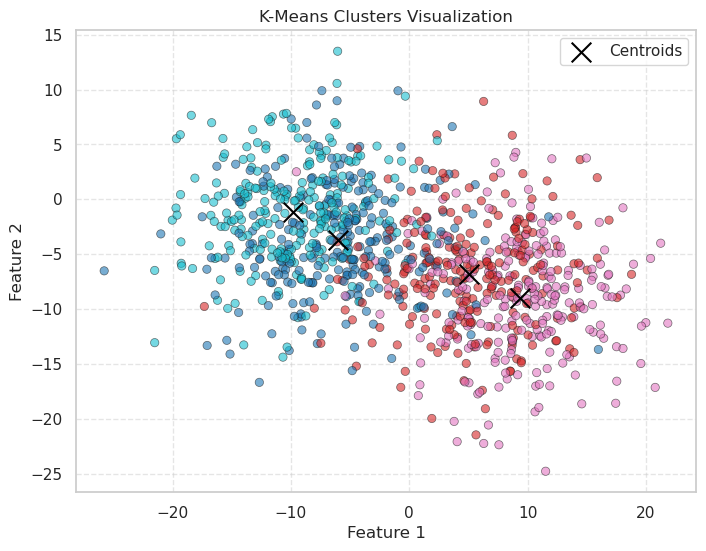

In [33]:
cen, lbls, _ = kmeans(X, n_clusters=4, random_state=91,distance='manhattan')
plotkmeans(X, cen, lbls, title='K-Means Clusters Visualization')

Figure 2: K-Means clustering result on the synthetic dataset (std = 3.0), using the Manhattan distance. Predicted clusters are shown with colored points and the centroids are marked with black "X".

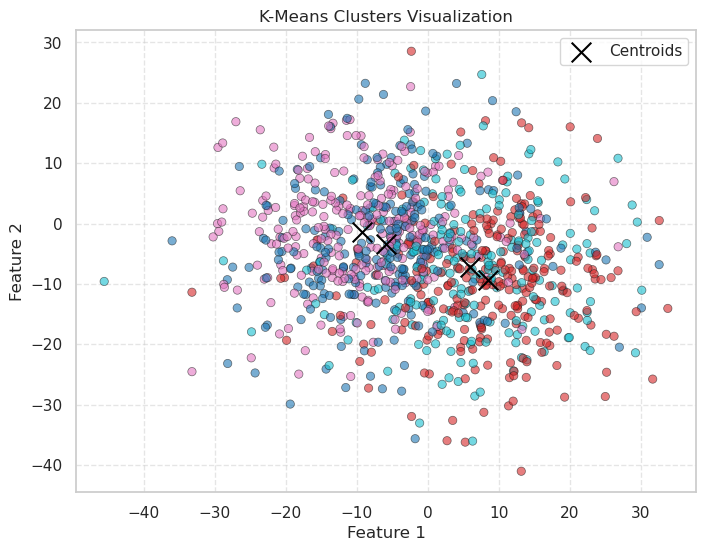

In [32]:
Xn, yn = make_blobs(n_samples=1000,n_features=10,centers=4,cluster_std=10.0,random_state=91)
cen, lbls, _ = kmeans(Xn, n_clusters=4, random_state=91,distance='manhattan')
plotkmeans(Xn, cen, lbls, title='K-Means Clusters Visualization')

Figure 3: K-Means clustering on a noisier version of the dataset (std = 10.0). Clusters show heavy overlap, which increases misclassification risk and causes centroid drift.

As we can see from *Figures 2 and 3*, as the standard deviation increases, the clusters begin to overlap more significantly. This visual observation suggests that higher noise levels may lead to misclustered points, as the boundaries between clusters become less distinct and the centroids are drawn closer to each other.

### Noise Comparison
To evaluate the effectiveness of different clustering algorithms under varying levels of noise, I conduct a benchmark using datasets generated with different standard deviations (std). These deviations simulate increasing cluster overlap, making the clustering task more challenging as noise increases.

I assess performance using two key evaluation metrics:
 * **Silhouette Coefficient *(Internal Index)*:** Measures the quality of clustering without reference to true labels. It evaluates how similar a point is to its own cluster compared to others. Higher scores indicate well-defined, separated clusters. It ranges from -1 to 1
 * **Adjusted Rand Index (ARI) *(External Index)*:** Measures similarity between predicted cluster labels and the ground truth. Although ARI is sometimes labeled as a relative index, it is more accurately considered an external index in our case because it compares true class labels. ARI adjusts for random label agreement, with scores ranging from -1 (worse than random) to 1 (perfect match). 

Each algorithm (including variations in initialization and distance metrics) is tested across a range of standard deviations. I categorize the noise levels as:

`Low Noise: std ≤ 3.0`

`High Noise: std > 3.0`

After running all experiments, I compute both the mean and median scores across noise levels for each algorithm configuration. These aggregated results help determine which clustering method is most robust and consistent under increasing noise.

In [41]:
import pandas as pd
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score

# 1) Benchmark settings
cluster_stds     = [0.5, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0, 15.0]
kmeans_distances = ['euclidean', 'manhattan', 'mahalanobis']
kmeans_inits     = ['kmeans++', 'random']
mog_inits        = ['random', 'kmeans']

results = []

# 2) Run Benchmark
for std in cluster_stds:
    X, y_true = make_blobs(
        n_samples=1000, n_features=10, centers=4,
        cluster_std=std, random_state=91
    )
    # K-Means variants
    for dist in kmeans_distances:
        for init in kmeans_inits:
            _, labels_k, _ = kmeans(X, n_clusters=4, distance=dist, init=init, random_state=91)
            results.append({
                'method': 'KMeans',
                'parameter': f"{dist}-{init}",
                'cluster_std': std,
                'ARI': adjusted_rand_score(y_true, labels_k),
                'Silhouette': silhouette_score(X, labels_k, metric=dist)
            })
    # MoG variants
    for init in mog_inits:
        _, labels_m, _ = MoG(X, n_components=4, init=init, random_state=91)
        results.append({
            'method': 'MoG',
            'parameter': init,
            'cluster_std': std,
            'ARI': adjusted_rand_score(y_true, labels_m),
            'Silhouette': silhouette_score(X, labels_m, metric='euclidean')
        })

# 3) Create DataFrame
df = pd.DataFrame(results)

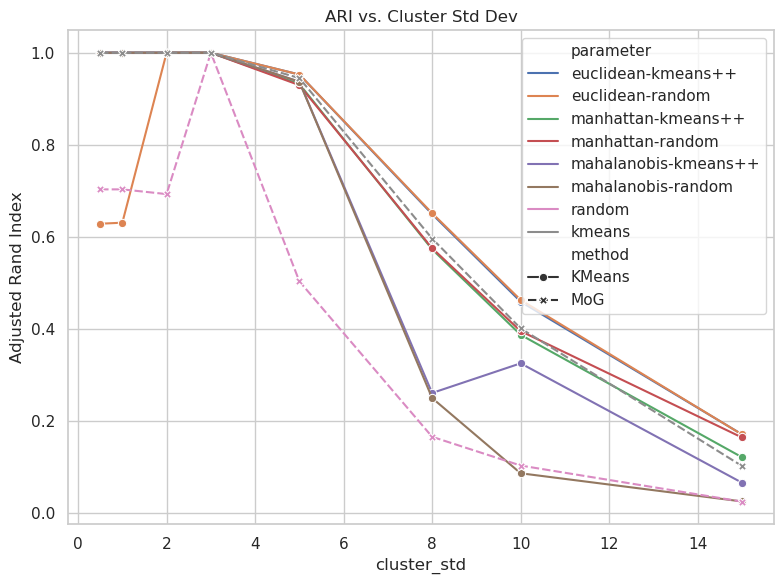

In [42]:
# 1)Plot ARI vs. noise
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df, x='cluster_std', y='ARI',
    hue='parameter', style='method', markers=True
)
plt.title("ARI vs. Cluster Std Dev")
plt.xlabel("cluster_std")
plt.ylabel("Adjusted Rand Index")
plt.tight_layout()
plt.show()



Figure 4: Line plot of Adjusted Rand Index (ARI) versus cluster standard deviation for all algorithm variants. The ARI decreases with noise, indicating reduced clustering accuracy.

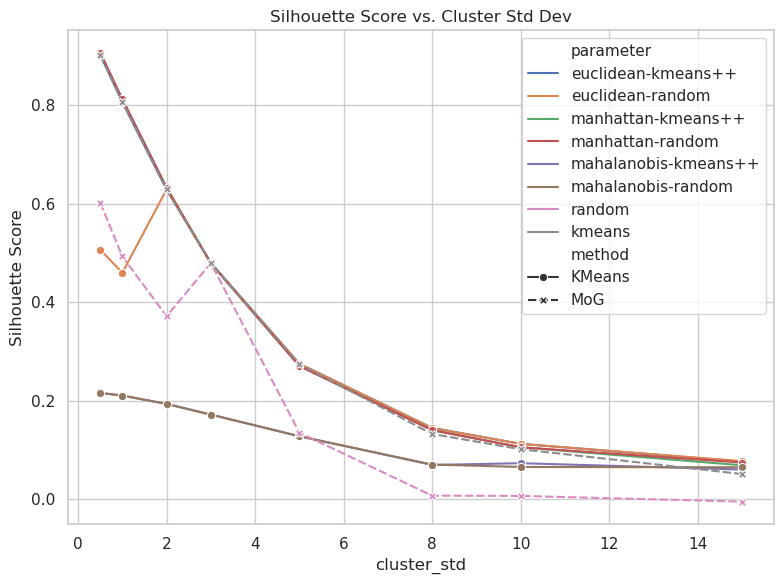

In [36]:
# 2) Plot Silhouette vs. noise
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df, x='cluster_std', y='Silhouette',
    hue='parameter', style='method', markers=True
)
plt.title("Silhouette Score vs. Cluster Std Dev")
plt.xlabel("cluster_std")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

Figure 5: Silhouette Score plotted against cluster standard deviation. This internal index reflects how well-separated the clusters are. Higher noise results in lower silhouette scores.

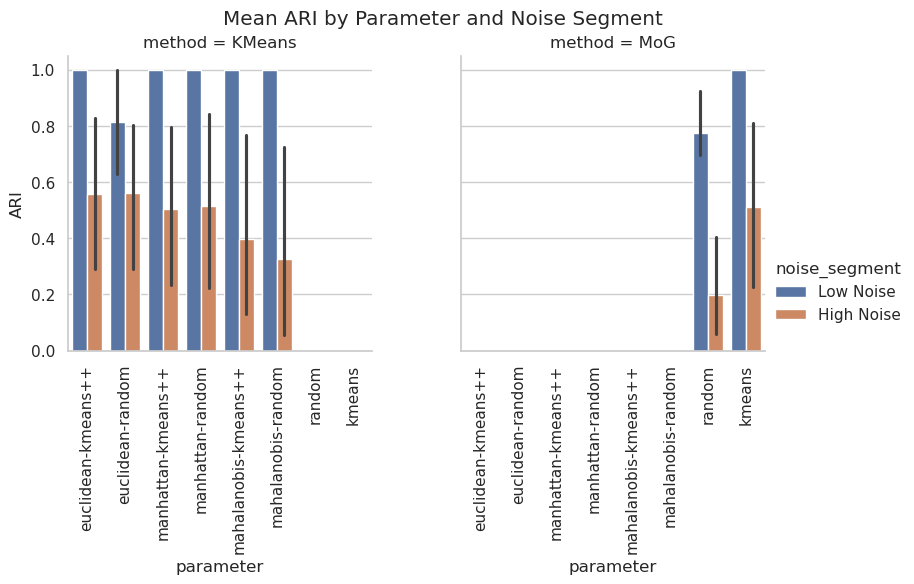

In [37]:
# 3) Mean ARI by Parameter & Noise Segment
df['noise_segment'] = np.where(df['cluster_std'] <= 3.0, 'Low Noise', 'High Noise')

g = sns.catplot(
    data=df, x='parameter', y='ARI', hue='noise_segment',
    col='method', kind='bar', height=4, aspect=1
)
g.set_xticklabels(rotation=90)
plt.suptitle("Mean ARI by Parameter and Noise Segment", y=1.02)
plt.show()

Figure 6: Bar chart of mean ARI scores for different algorithm configurations, separated by low (≤3) and high (>3) noise segments. Useful for identifying robust clustering setups.

In [31]:
# Determine best method by median ARI (cool groupby)
median_ari = df.groupby(['method','parameter'])['ARI']\
               .median()\
               .reset_index(name='Median_ARI')\
               .sort_values('Median_ARI', ascending=False)

print("Median ARI ranking:")
print(median_ari)

best = median_ari.iloc[0]
print(f"\nBest overall: {best['method']} with parameter '{best['parameter']}' (median ARI={best['Median_ARI']:.3f})")

Median ARI ranking:
   method             parameter  Median_ARI
0  KMeans    euclidean-kmeans++    0.976376
6     MoG                kmeans    0.972548
3  KMeans    mahalanobis-random    0.968563
2  KMeans  mahalanobis-kmeans++    0.968560
4  KMeans    manhattan-kmeans++    0.966100
5  KMeans      manhattan-random    0.964852
1  KMeans      euclidean-random    0.641325
7     MoG                random    0.598395

Best overall: KMeans with parameter 'euclidean-kmeans++' (median ARI=0.976)


In [29]:
# Compute best method by mean ARI
mean_ari = df.groupby(['method','parameter'])['ARI'] \
             .mean() \
             .reset_index(name='Mean_ARI') \
             .sort_values('Mean_ARI', ascending=False)

print("Mean ARI ranking:")
print(mean_ari)

best_mean = mean_ari.iloc[0]
print(f"\nBest overall by average: {best_mean['method']} with parameter '{best_mean['parameter']}' "
      f"(mean ARI={best_mean['Mean_ARI']:.3f})")

Mean ARI ranking:
   method             parameter  Mean_ARI
0  KMeans    euclidean-kmeans++  0.779163
5  KMeans      manhattan-random  0.758189
6     MoG                kmeans  0.755732
4  KMeans    manhattan-kmeans++  0.751830
2  KMeans  mahalanobis-kmeans++  0.698796
1  KMeans      euclidean-random  0.687327
3  KMeans    mahalanobis-random  0.662484
7     MoG                random  0.487315

Best overall by average: KMeans with parameter 'euclidean-kmeans++' (mean ARI=0.779)


/tmp/ipykernel_2014/3216204497.py:56: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


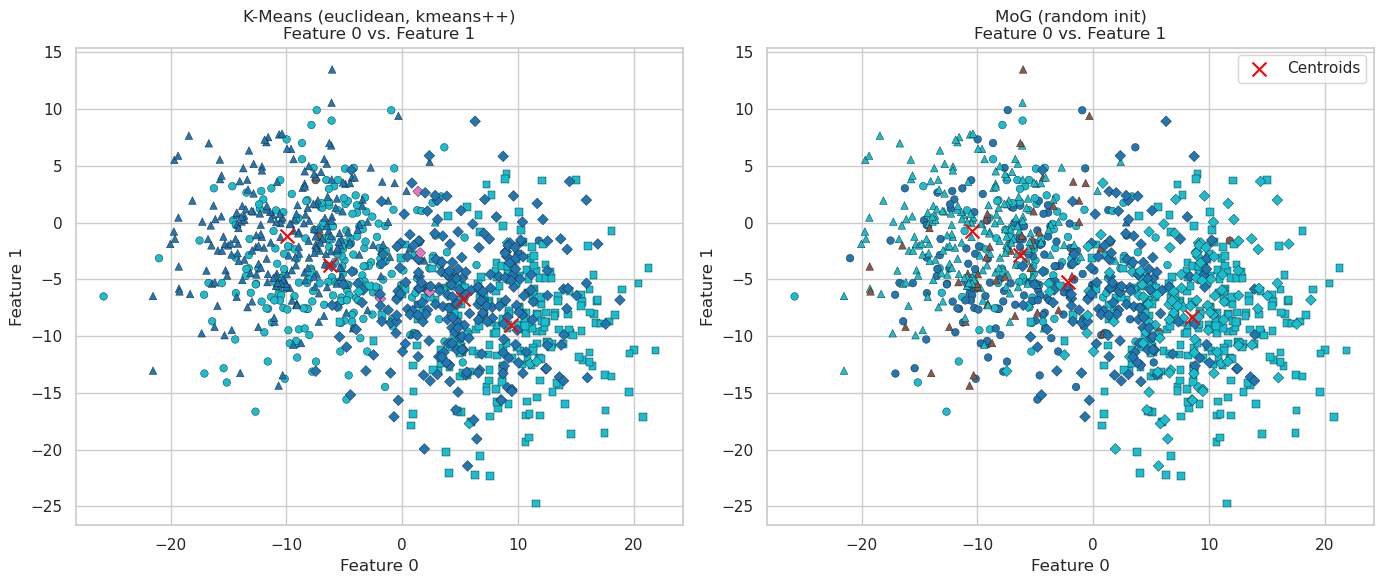

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 1) Generate data and fit models
X, y_true = make_blobs(
    n_samples=1000,
    n_features=10,
    centers=4,
    cluster_std=5.0,
    random_state=91
)

cent_k, labels_k, _ = kmeans(
    X,
    n_clusters=4,
    distance='euclidean',
    init='kmeans++',
    random_state=91
)

cent_m, labels_m, _ = MoG(
    X,
    n_components=4,
    init='random',
    random_state=91
)

# 2) Use raw features 0 and 1 for plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

titles = [
    "K-Means (euclidean, kmeans++)",
    "MoG (random init)"
]
results = [
    (labels_k, cent_k),
    (labels_m, cent_m)
]

for ax, (labels_pred, centroids), title in zip(axes, results, titles):
    # Plot data: color by predicted cluster, shape by true label
    shapes = ['o', 's', '^', 'D']
    for true_label in np.unique(y_true):
        mask = (y_true == true_label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=labels_pred[mask],
            cmap='tab10',
            marker=shapes[true_label],
            edgecolor='k',
            linewidth=0.3,
            s=30
        )
    # Plot centroids in feature space (0 vs. 1)
    ax.scatter(
        centroids[:, 0], centroids[:, 1],
        c='red', marker='x',
        s=100, edgecolor='white',
        label='Centroids'
    )
    ax.set_title(f"{title}\nFeature 0 vs. Feature 1")
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


Figure 7: Side-by-side comparison of cluster assignments from K-Means (left) and Gaussian Mixture Models (right). Points are shaped by ground-truth class and colored by predicted cluster. K-Means with euclidean distance and non-random init shows smoother boundaries in noisy conditions, since it has less shapes of differnt colors.

---

### Results

#### **Performance in Low-Noise Conditions (std ≤ 3.0):**

* All clustering algorithms performed well, with **high ARI (> 0.85)** and **Silhouette scores near 0.5–0.7**.
* **K-Means with Euclidean distance and KMeans++ initialization** consistently achieved the best performance in this range.
* The clusters were well-separated, allowing hard-assignment algorithms like K-Means to succeed.

#### **Performance in High-Noise Conditions (std > 3.0):**

* As noise increased, **Silhouette scores declined significantly**, indicating overlapping clusters and reduced internal cohesion.
* **ARI dropped**, especially for both K-Means and MoG variants espeicially in those using simple random initialization.
* While Gaussian Mixture Models whne utilizing kmeans offered flexibility through soft assignments, the results showed that K-Means—particularly with euclidean distance and KMeans++ initialization, often matched or exceeded MoG performance, even under noisy conditions. This suggests that with good initialization and distance selection, K-Means can remain competitive across a range of noise levels.
#### **Best Overall Performers:**

* For both **low noise** and  **high noise**, **K-Means (Euclidean, KMeans++)** provided fast and accurate results.

#### Metric Trends:

* **Silhouette Score** decreased steadily as cluster\_std increased, reflecting deteriorating separation.
* **ARI** showed a similar trend but varied more depending on algorithm configuration, especially when poor initialization amplified misclassification.


